# Estimate forcing for 1pctCO2 using parameters obtained from abrupt-4xCO2

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from plotting_functions import *
from estimation import *
#import importlib
#import my_functions as f
#importlib.reload(f) # needed to load new changes in my_functions
#import warnings
#warnings.filterwarnings('ignore')
plt.rcParams.update({'figure.max_open_warning': 0})

saveforcingdata = False # create one file for each model/member, combine them later if needed
saveforcingfigure = False
save_tasdiff = False


## Find models with both abrupt-4xCO2 and 1pctCO2 experiments

In [2]:
experiments = {}
directory = '../Processed_data/Global_annual_anomalies/'
model_names = [ f.name for f in os.scandir(directory) if f.is_dir() and f.name !='.ipynb_checkpoints']
model_names.sort()
model_names.remove('CIESM')
model_names.remove('CAS-ESM2-0')
model_names.remove('MIROC-ES2H')

In [3]:
model_names

['ACCESS-CM2',
 'ACCESS-ESM1-5',
 'AWI-CM-1-1-MR',
 'BCC-CSM2-MR',
 'BCC-ESM1',
 'CAMS-CSM1-0',
 'CESM2',
 'CESM2-FV2',
 'CESM2-WACCM',
 'CESM2-WACCM-FV2',
 'CMCC-CM2-SR5',
 'CMCC-ESM2',
 'CNRM-CM6-1',
 'CNRM-CM6-1-HR',
 'CNRM-ESM2-1',
 'CanESM5',
 'E3SM-1-0',
 'EC-Earth3',
 'EC-Earth3-AerChem',
 'EC-Earth3-CC',
 'EC-Earth3-Veg',
 'FGOALS-f3-L',
 'FGOALS-g3',
 'GFDL-CM4',
 'GFDL-ESM4',
 'GISS-E2-1-G',
 'GISS-E2-1-H',
 'GISS-E2-2-G',
 'GISS-E2-2-H',
 'HadGEM3-GC31-LL',
 'HadGEM3-GC31-MM',
 'ICON-ESM-LR',
 'IITM-ESM',
 'INM-CM4-8',
 'INM-CM5-0',
 'IPSL-CM5A2-INCA',
 'IPSL-CM6A-LR',
 'KIOST-ESM',
 'MIROC-ES2L',
 'MIROC6',
 'MPI-ESM-1-2-HAM',
 'MPI-ESM1-2-HR',
 'MPI-ESM1-2-LR',
 'MRI-ESM2-0',
 'NESM3',
 'NorCPM1',
 'NorESM2-LM',
 'NorESM2-MM',
 'SAM0-UNICON',
 'TaiESM1',
 'UKESM1-0-LL']

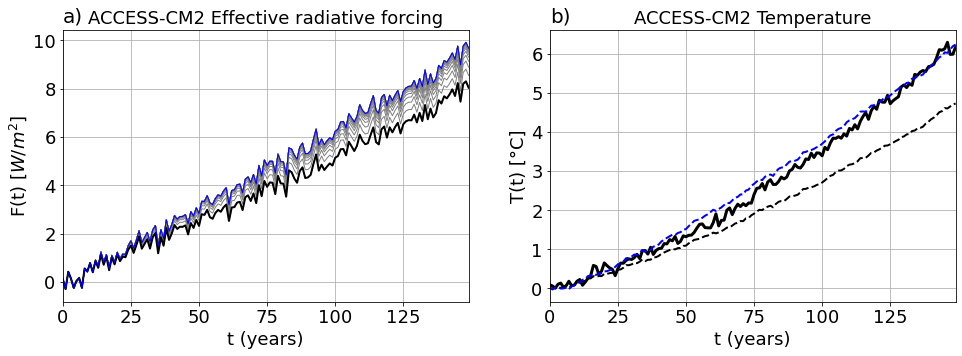

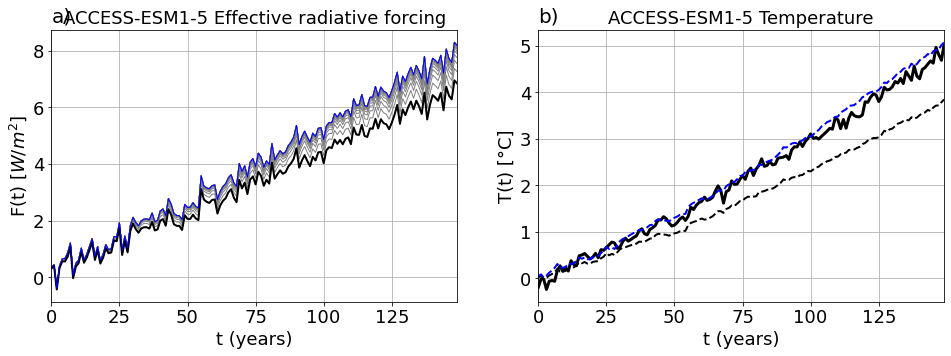

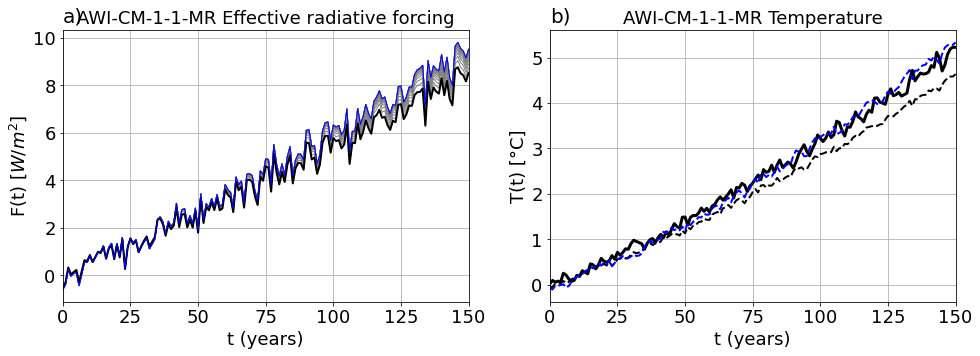

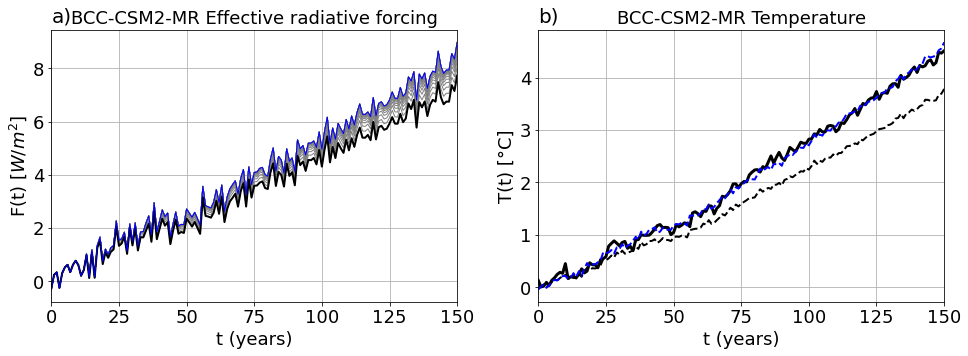

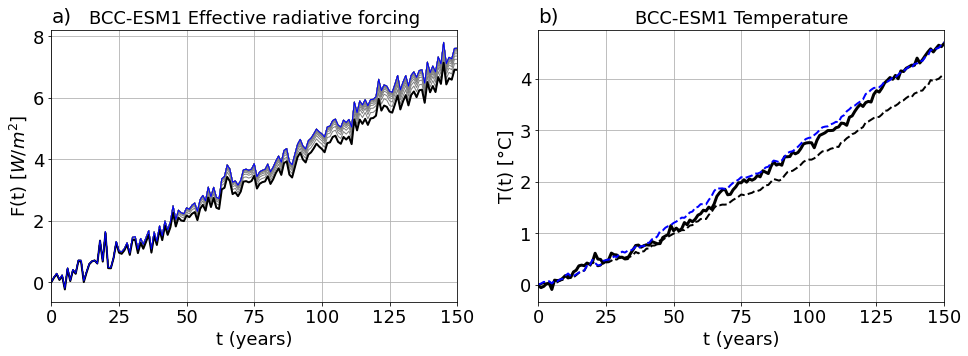

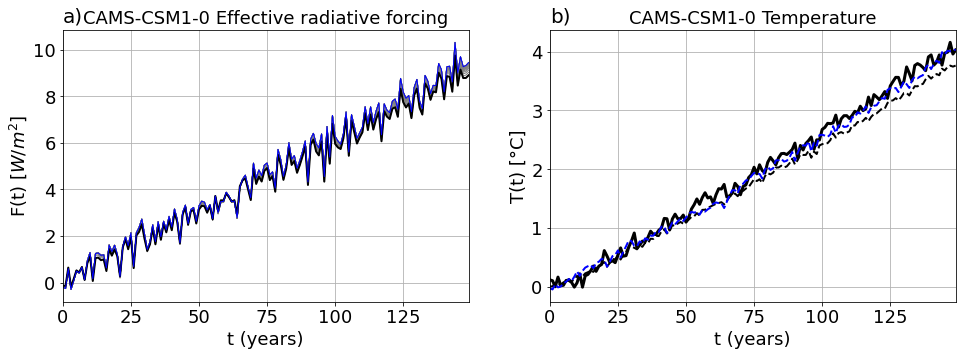

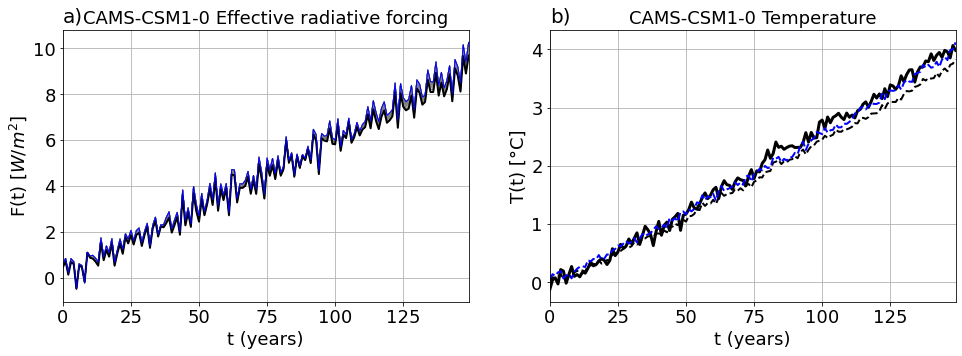

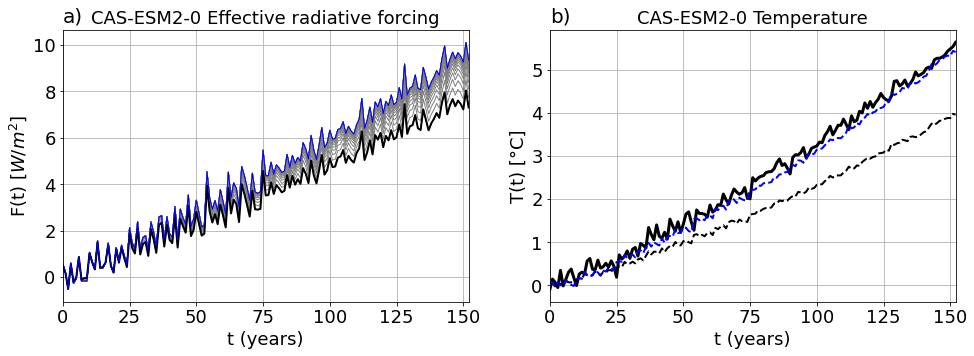

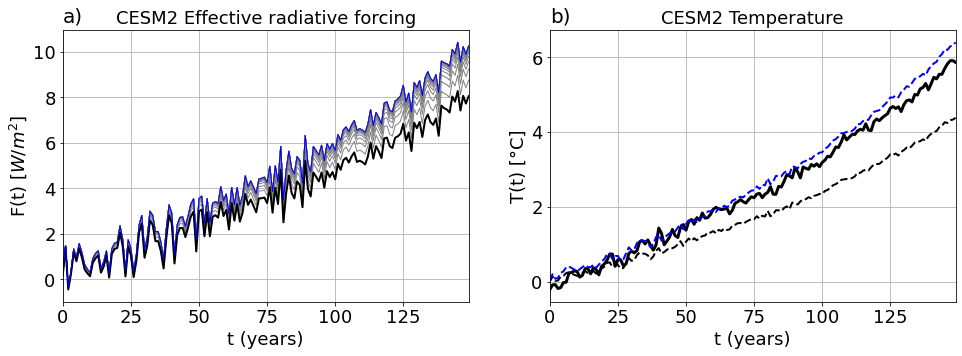

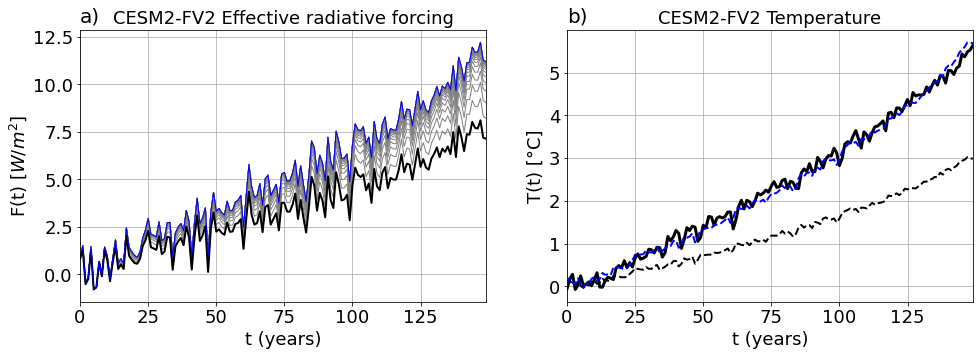

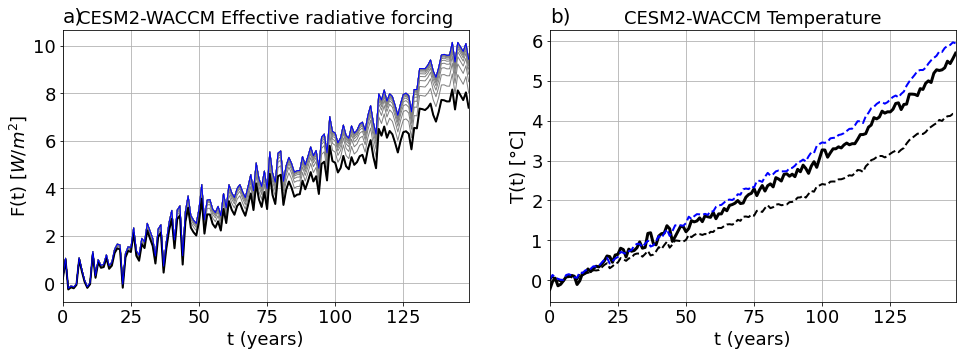

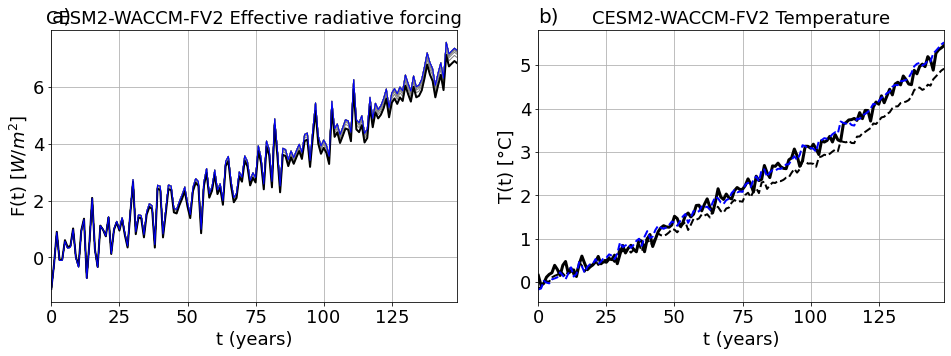

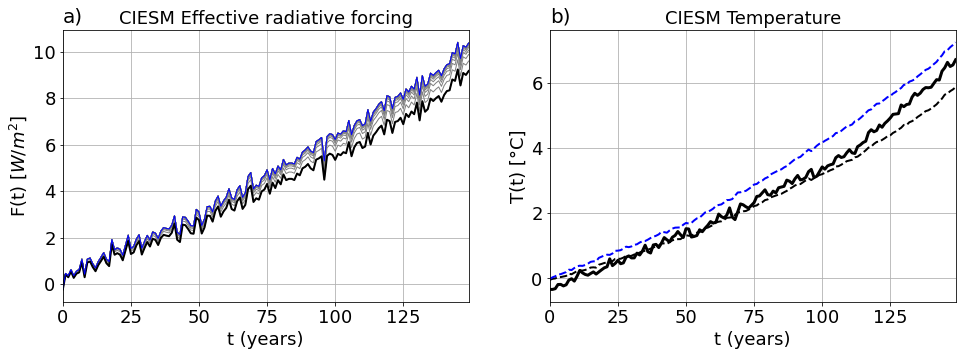

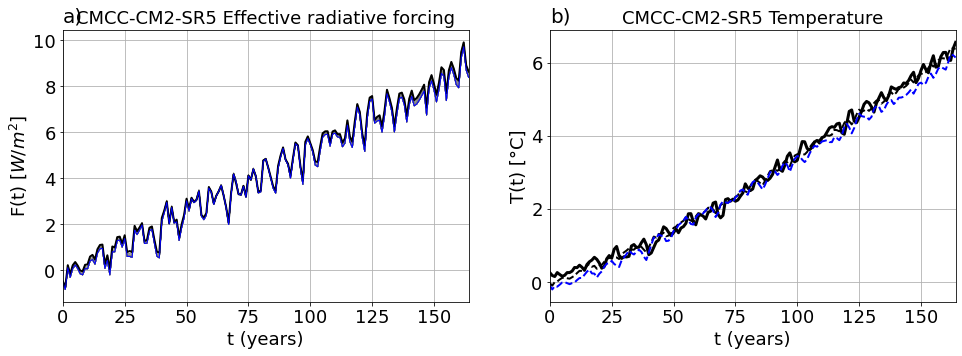

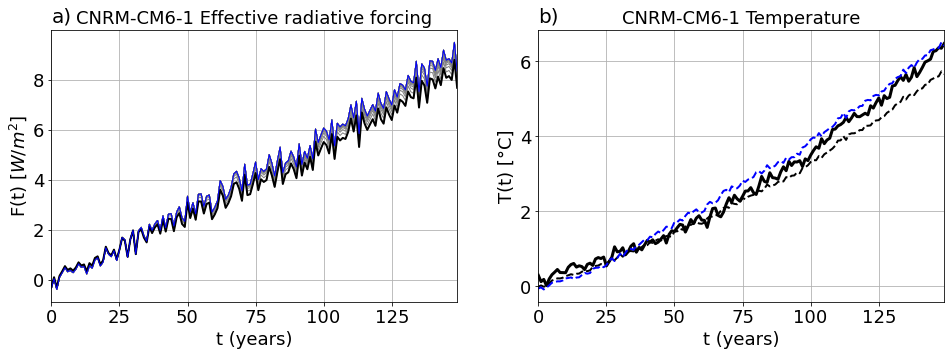

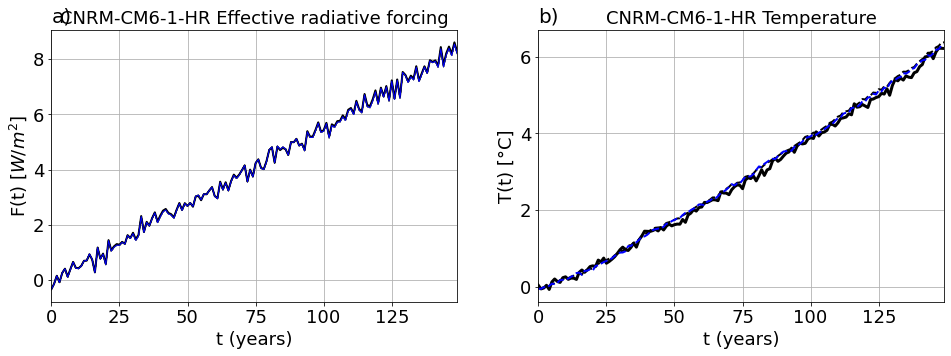

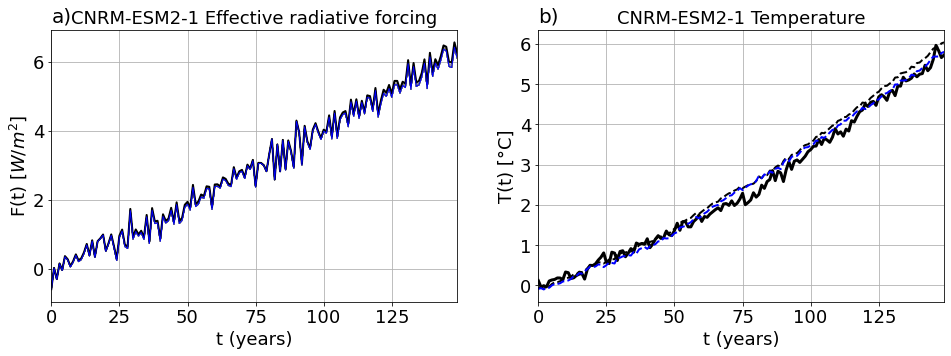

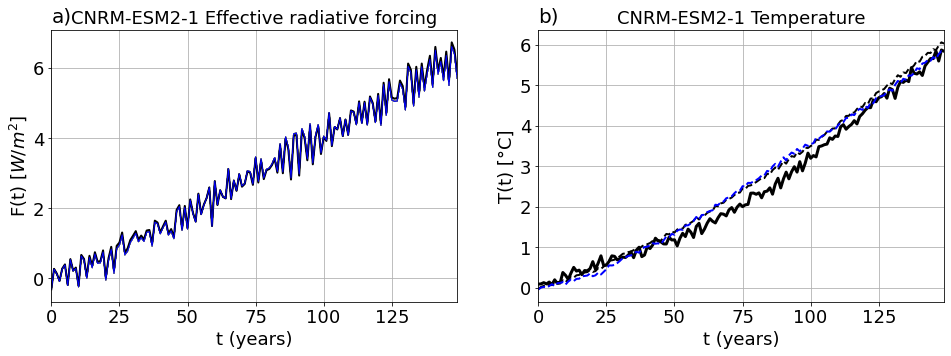

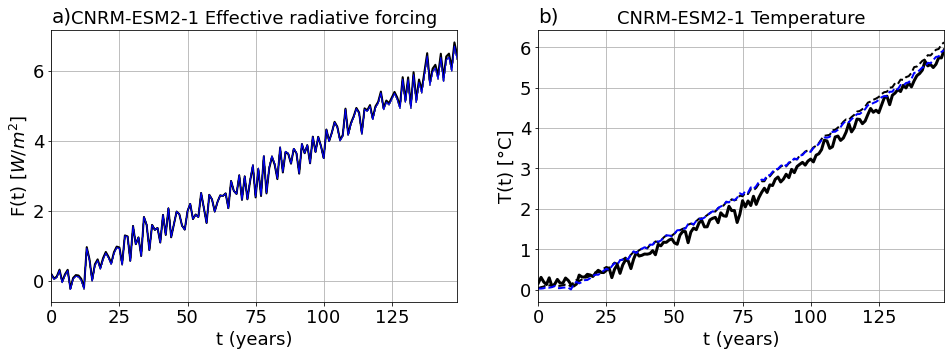

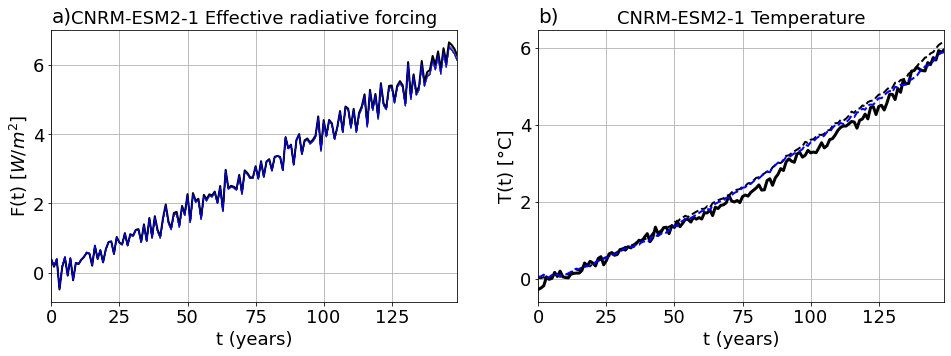

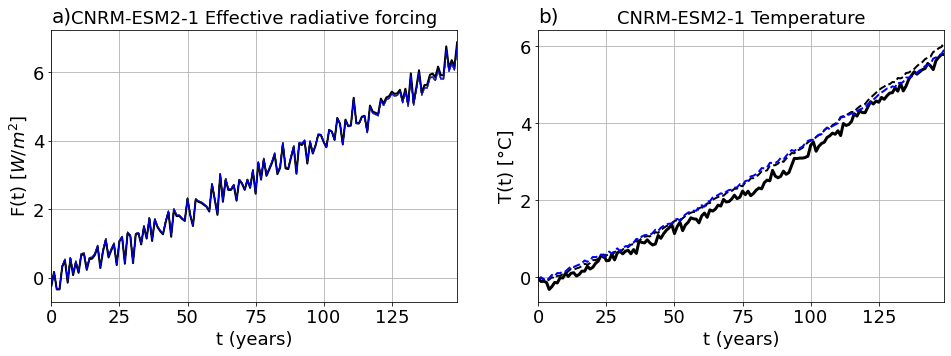

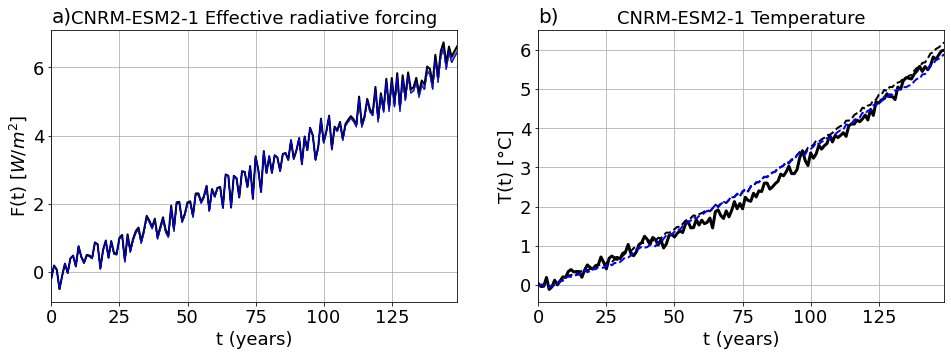

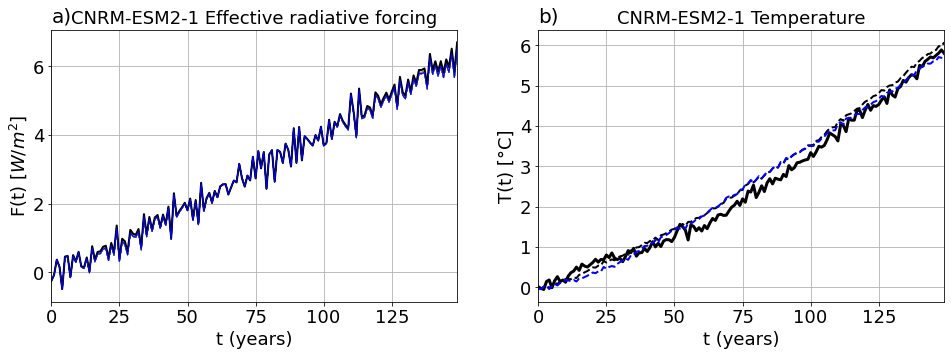

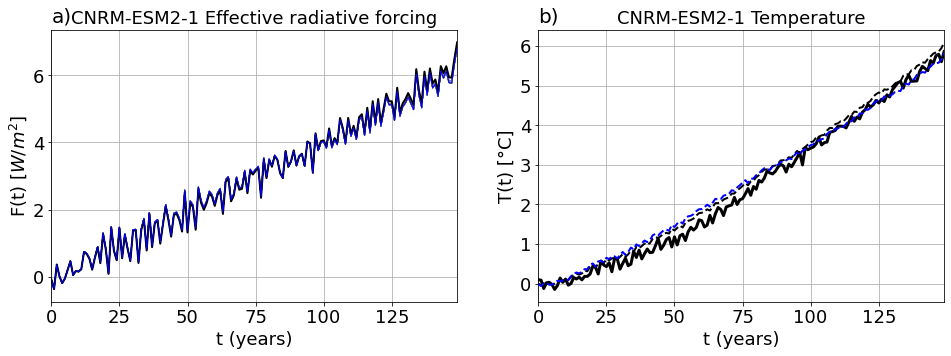

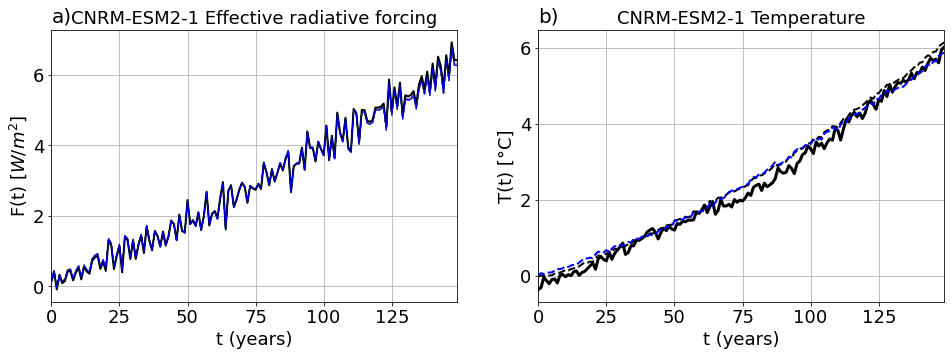

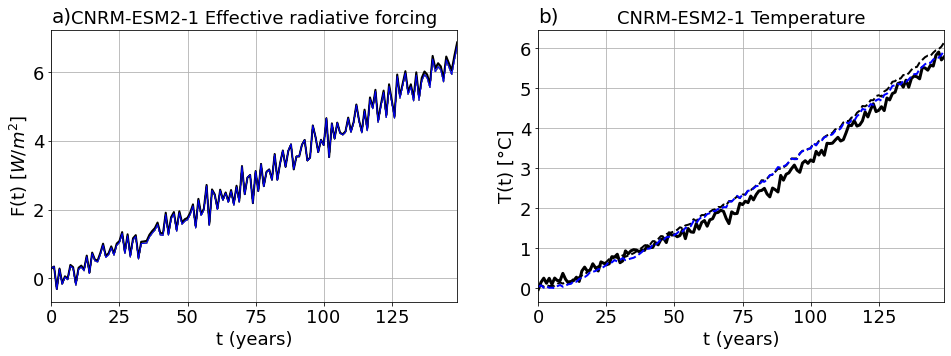

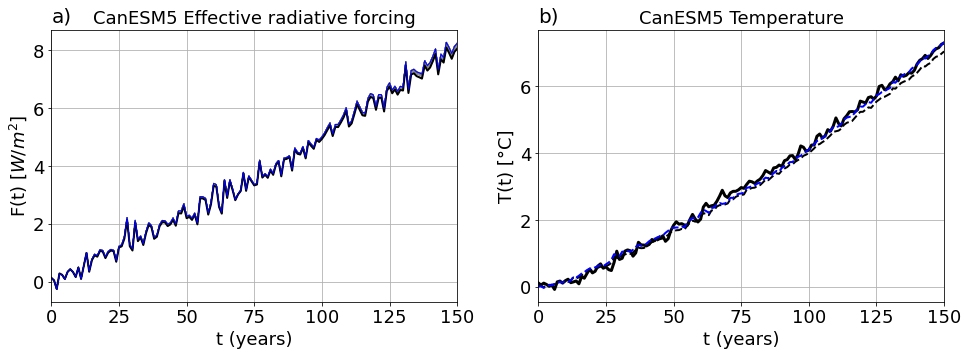

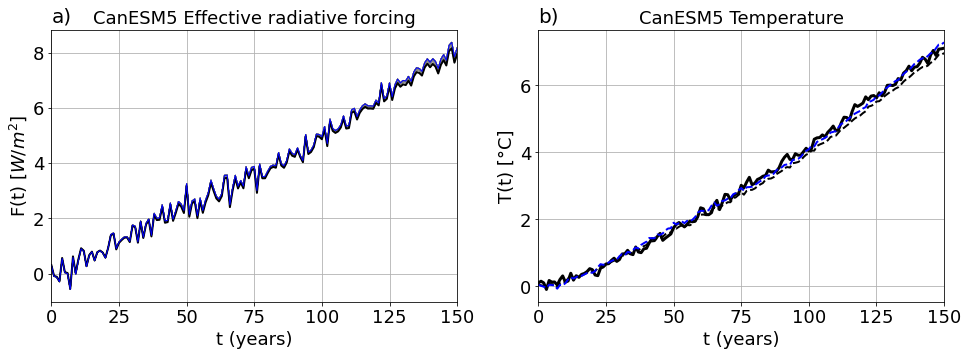

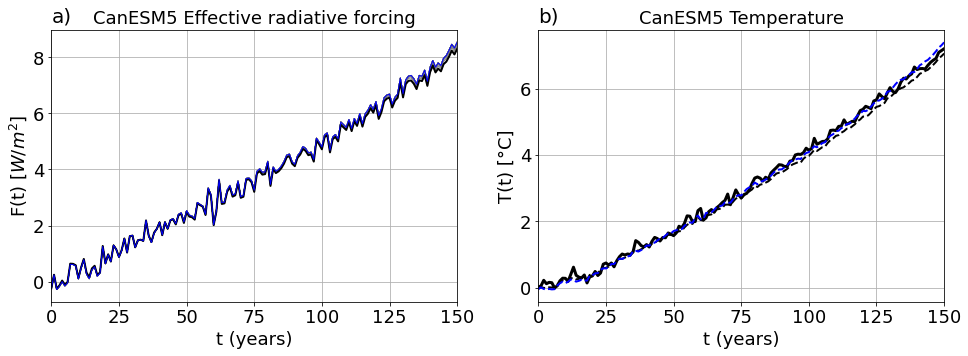

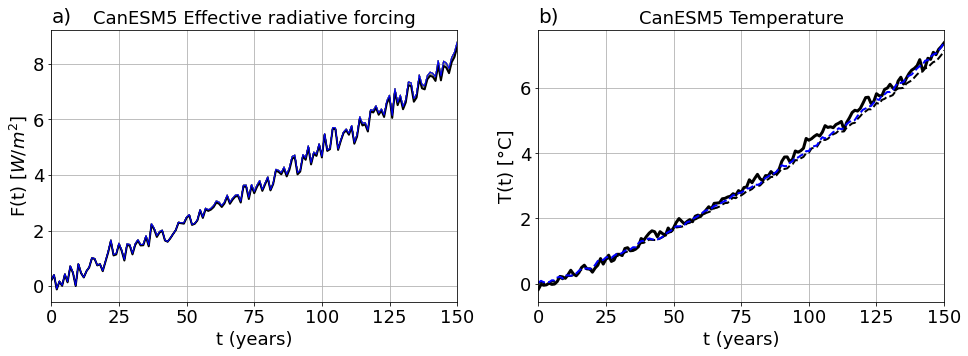

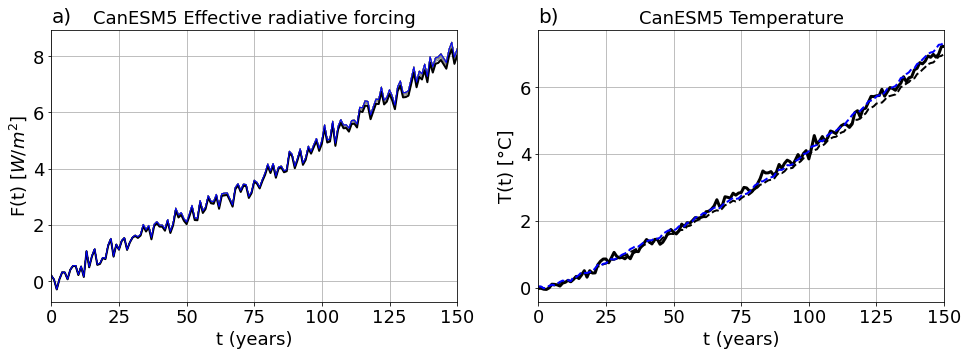

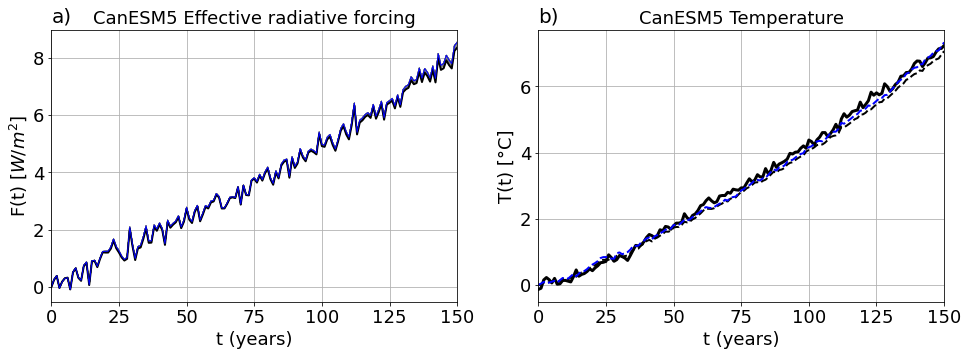

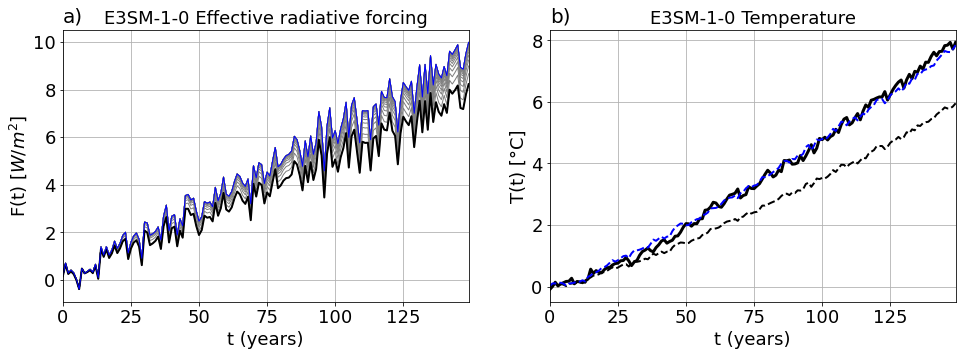

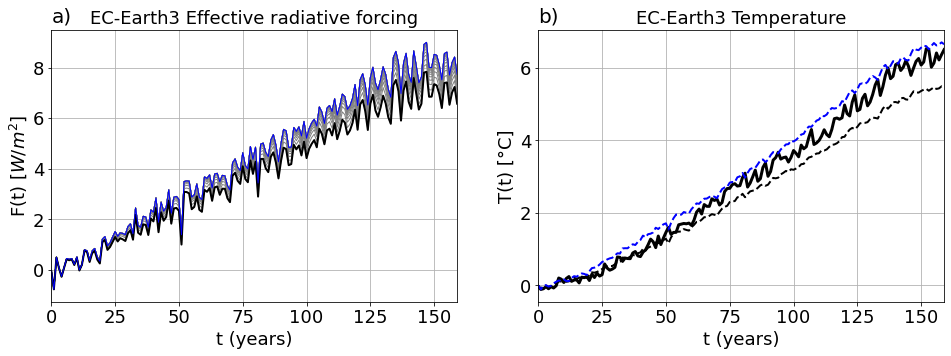

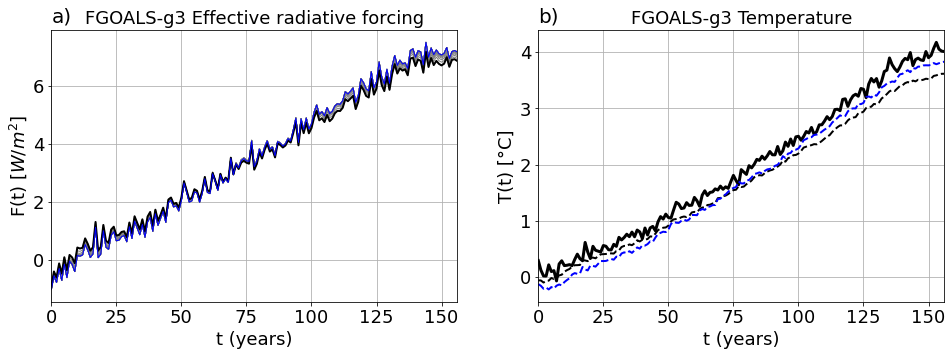

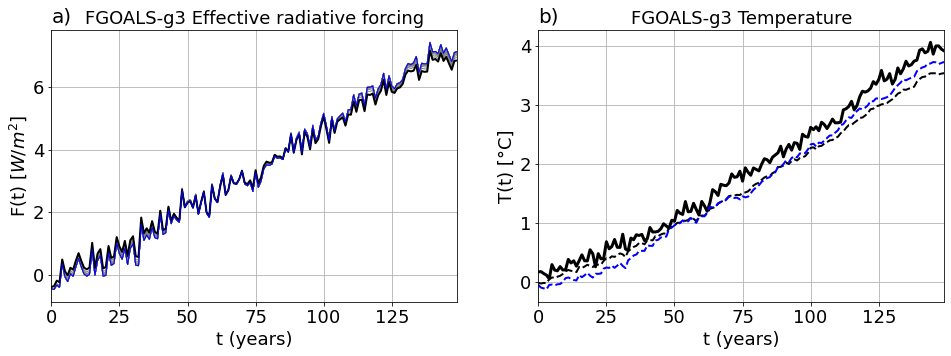

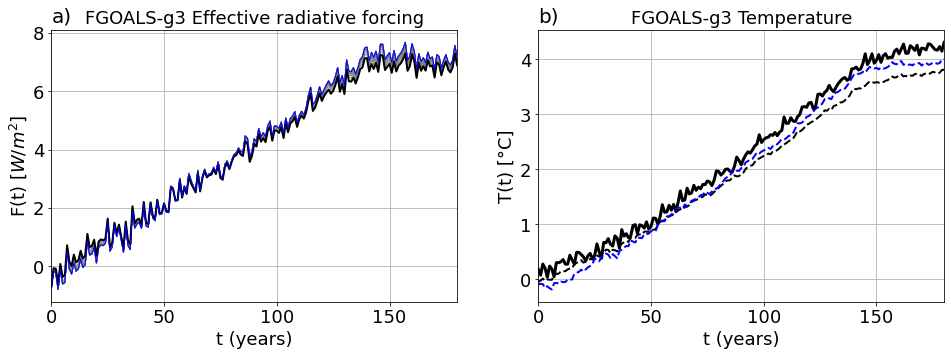

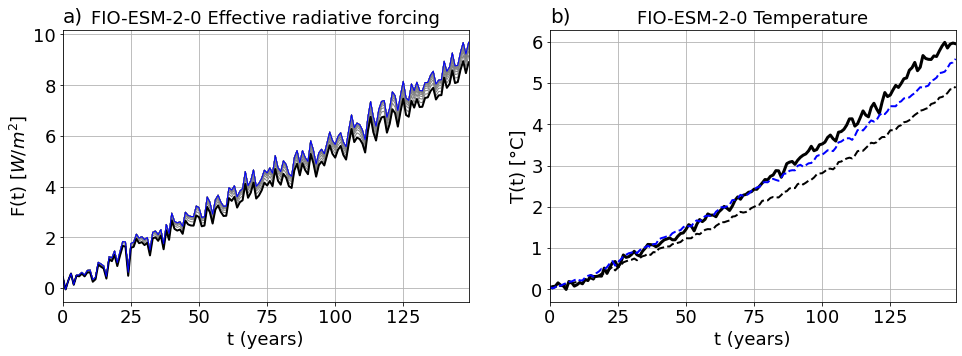

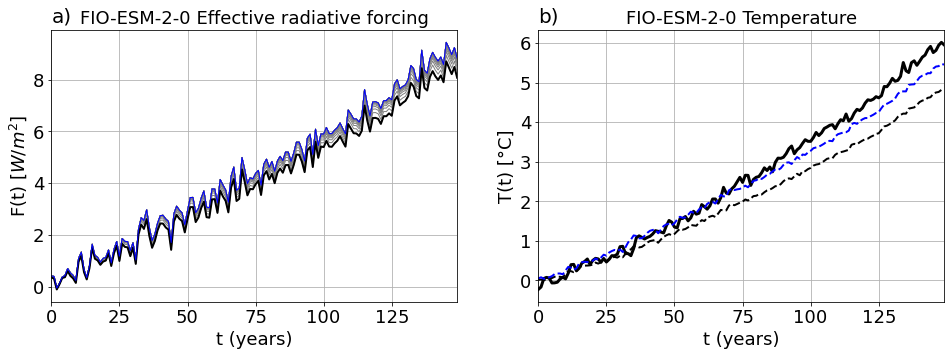

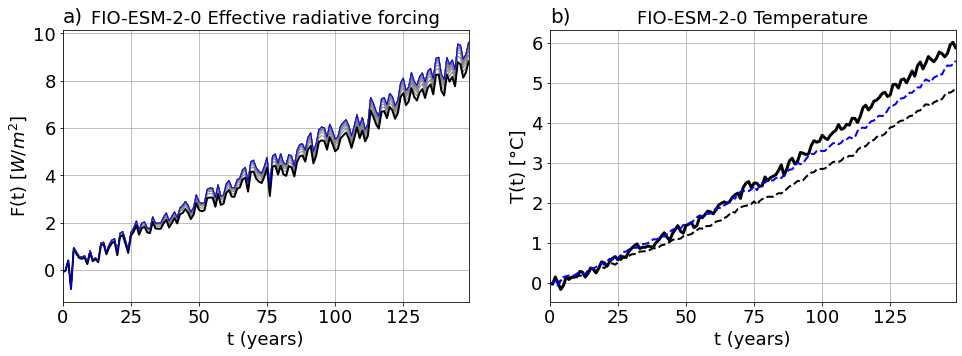

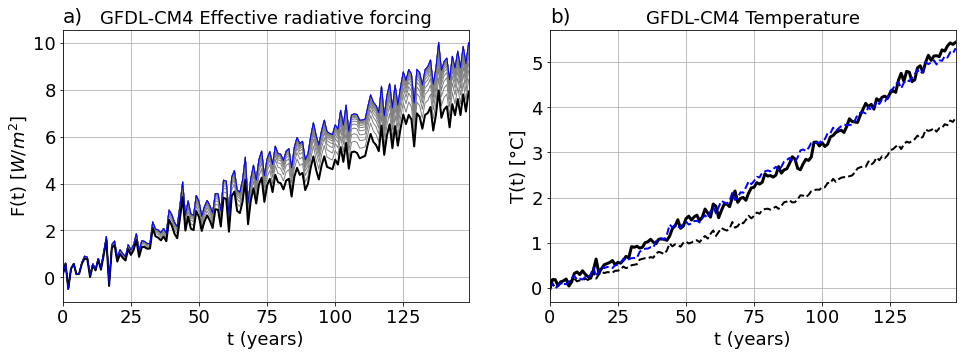

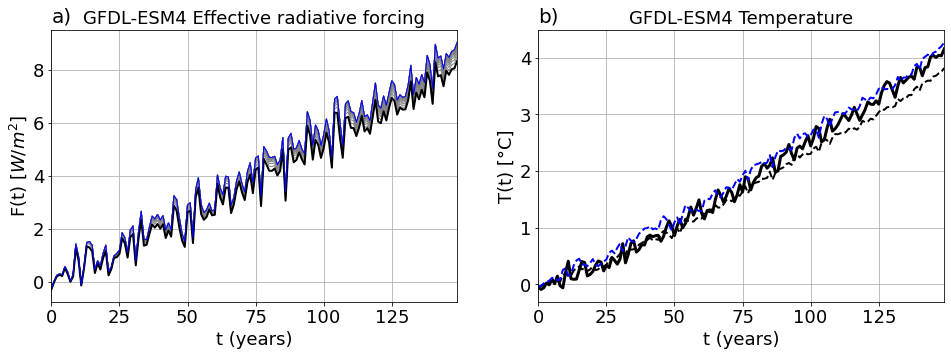

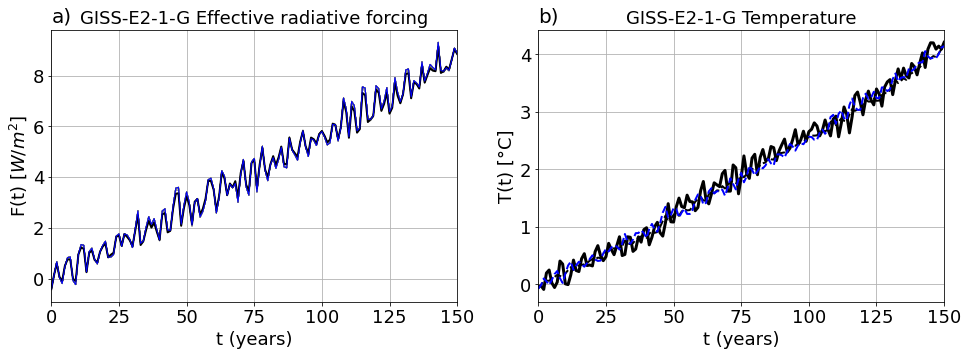

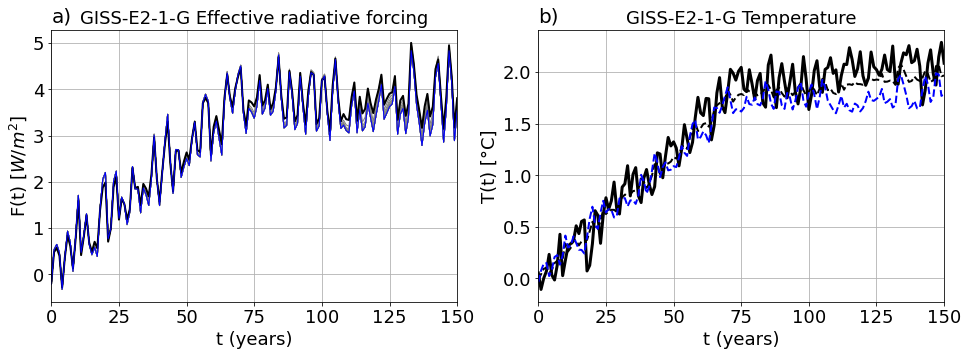

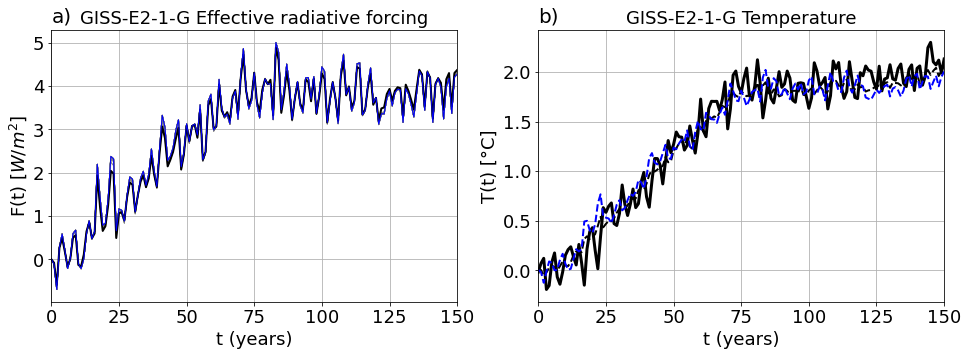

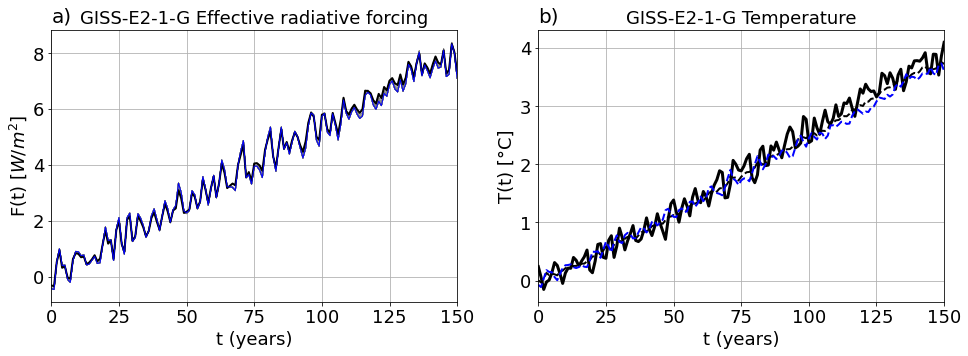

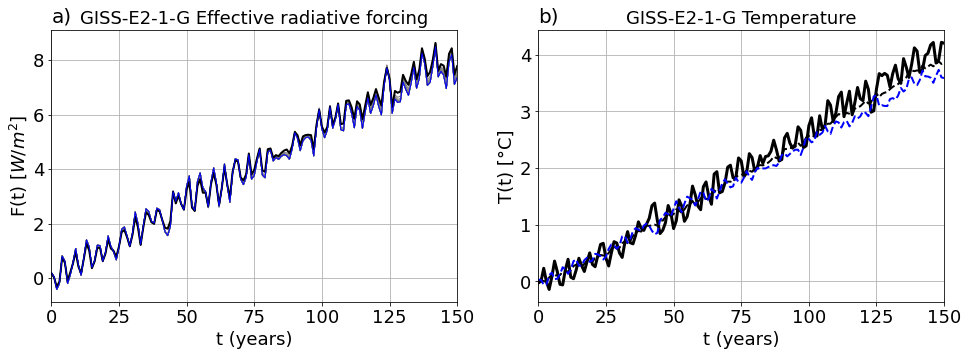

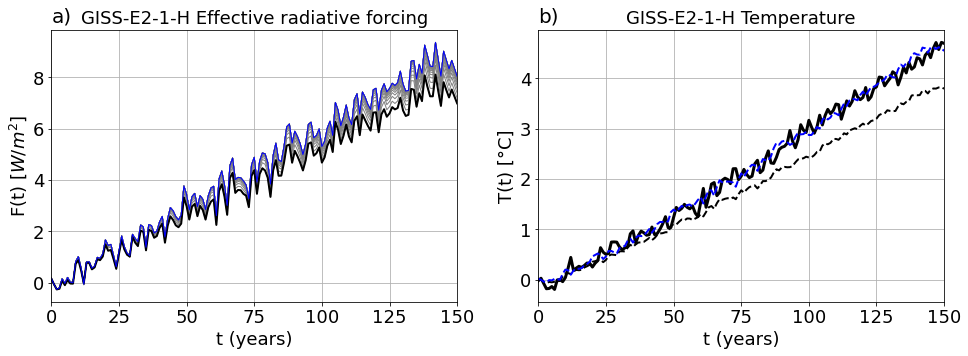

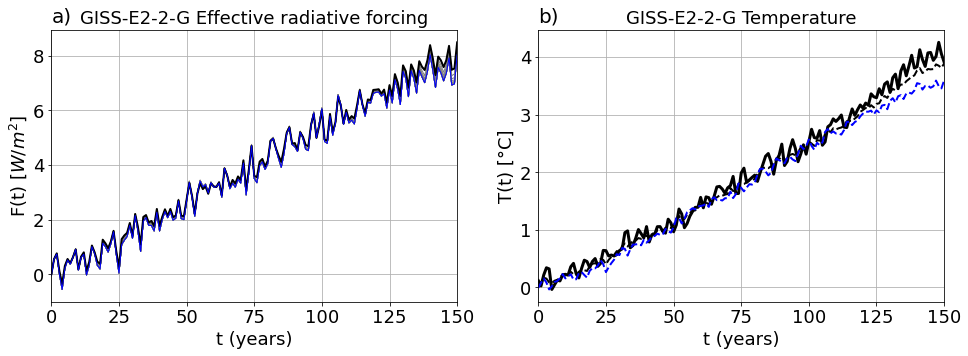

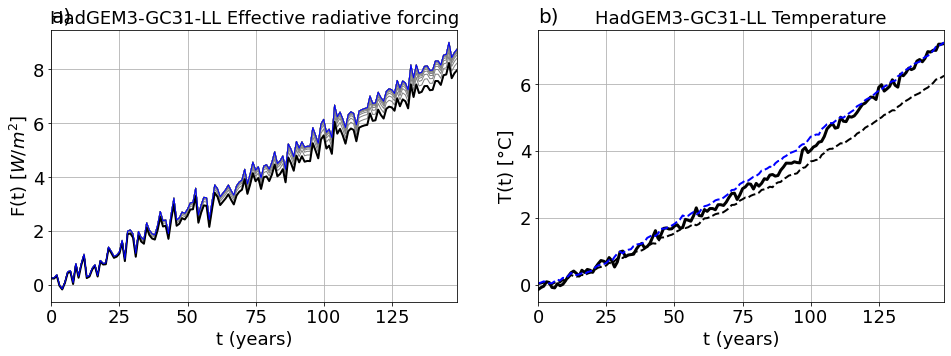

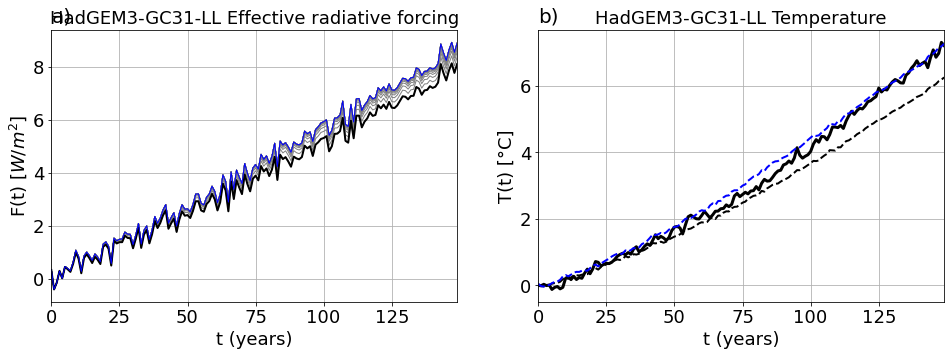

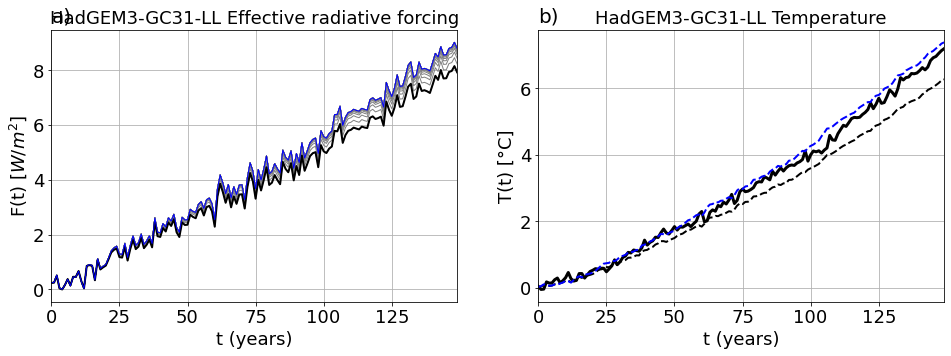

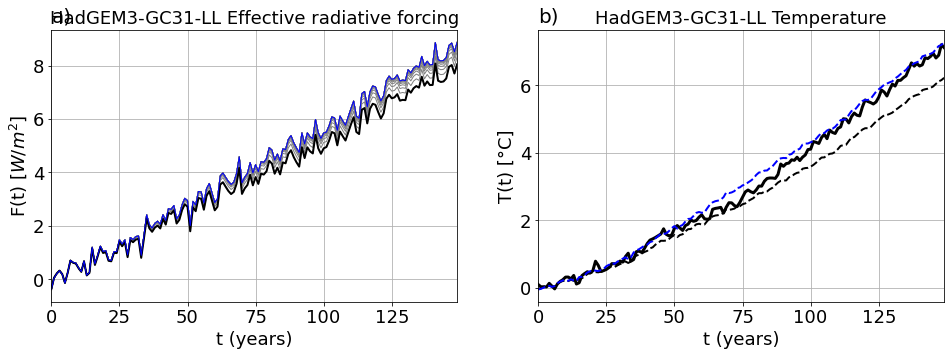

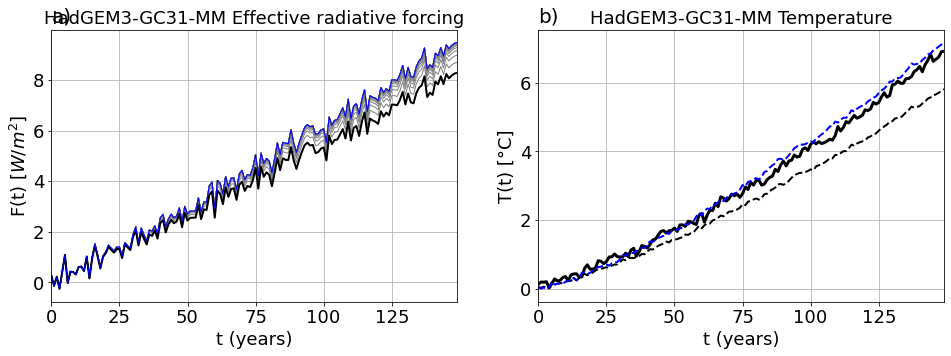

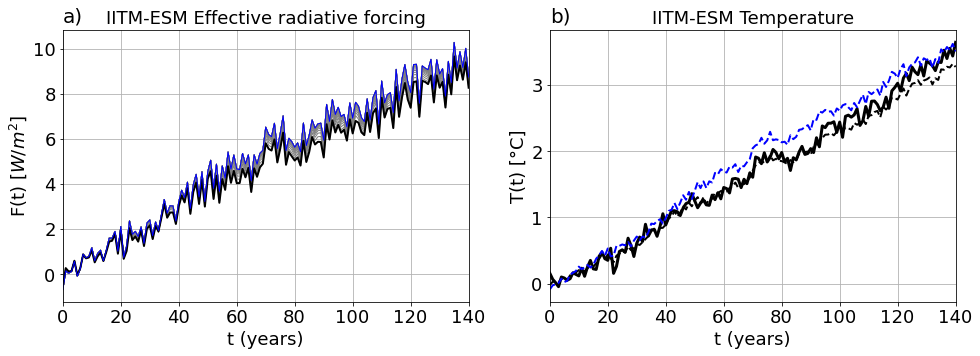

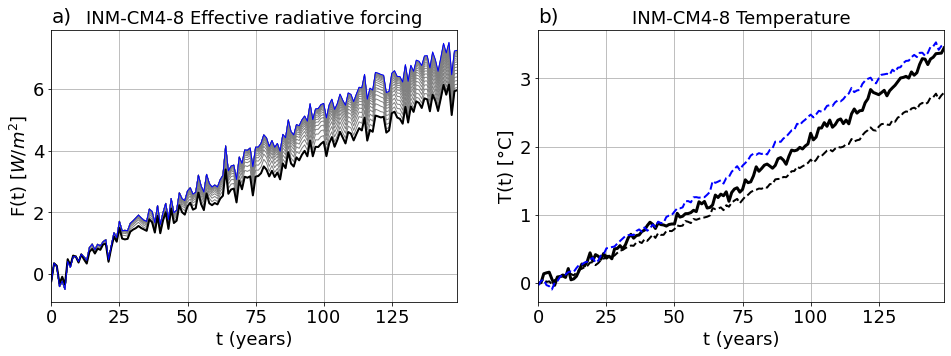

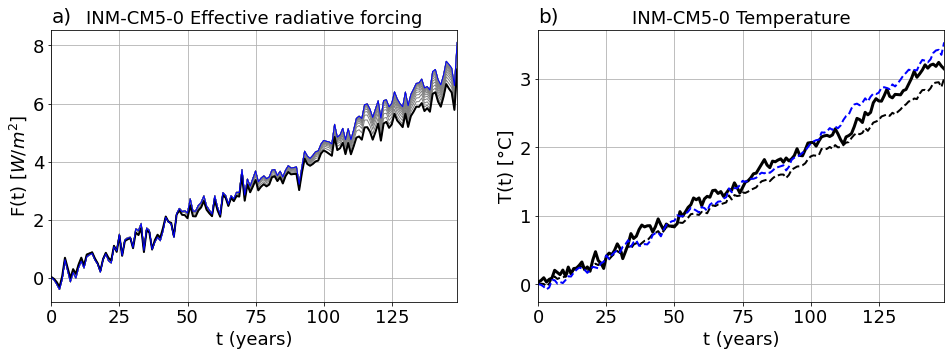

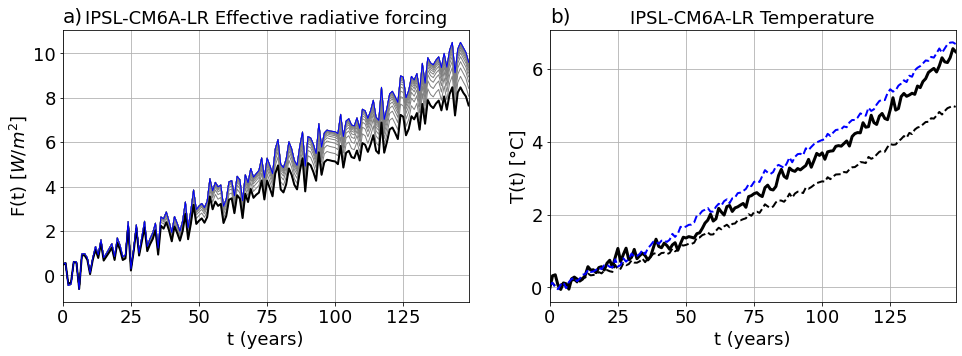

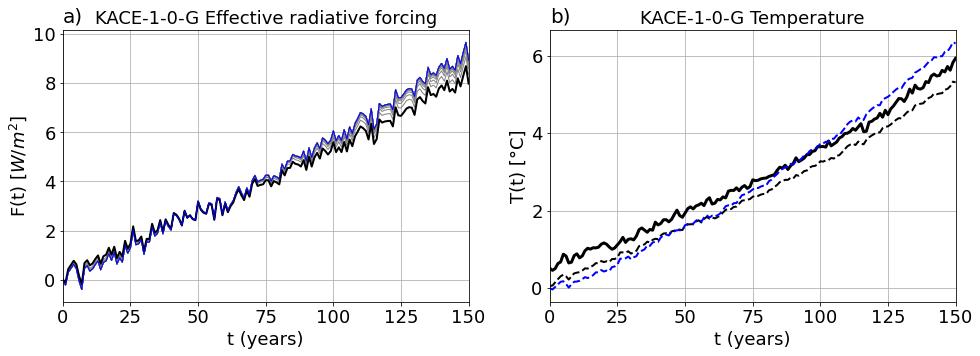

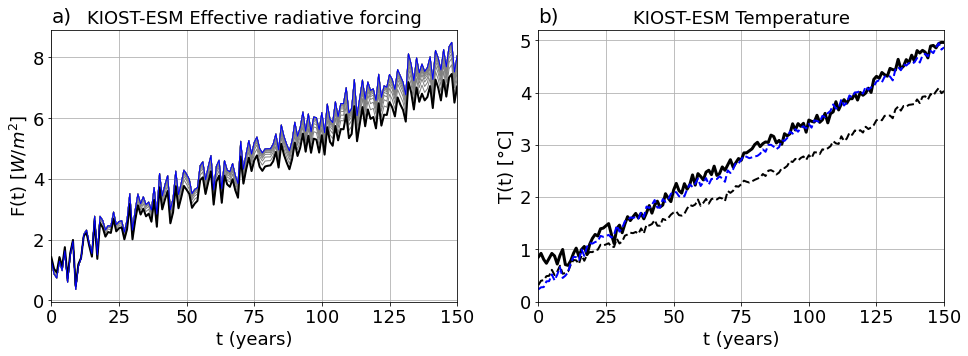

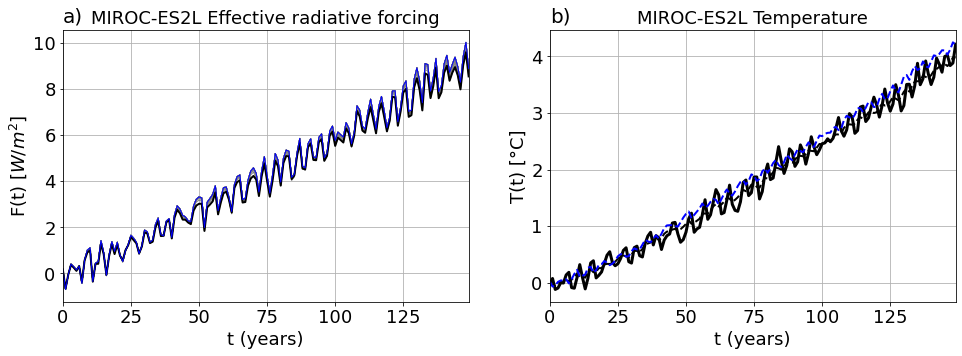

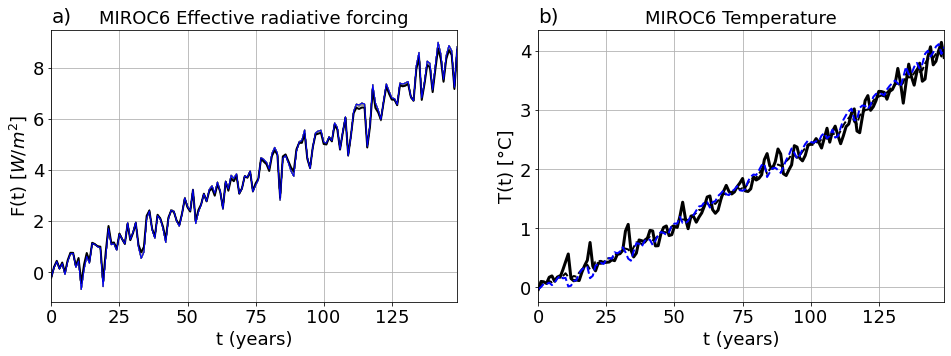

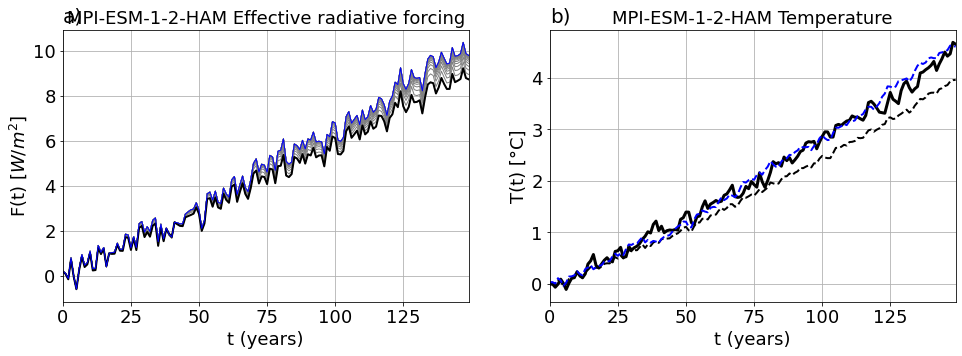

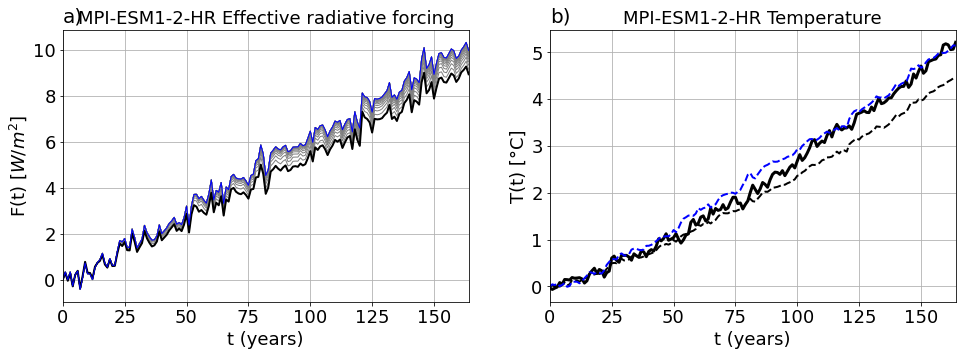

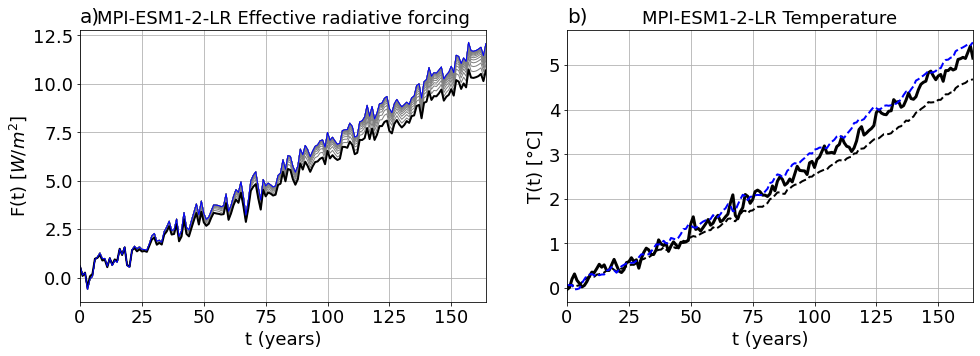

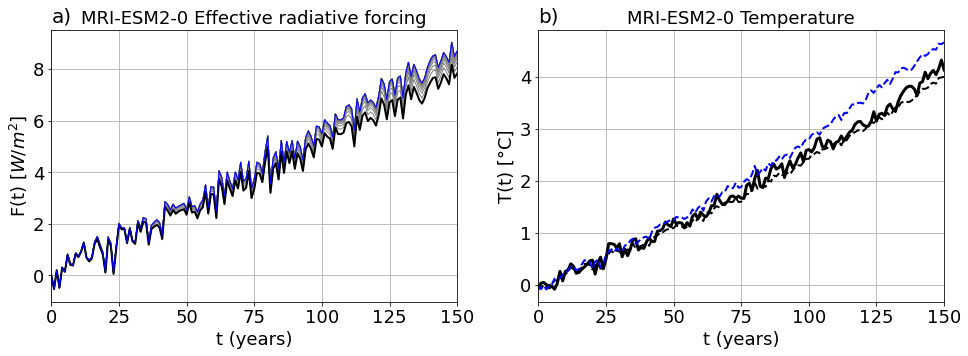

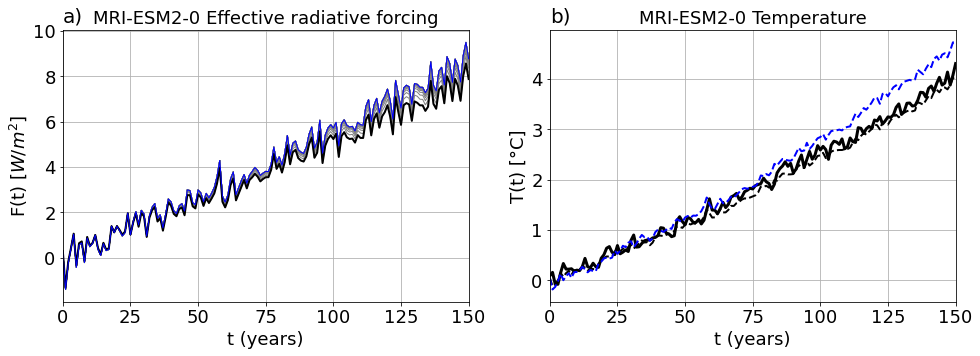

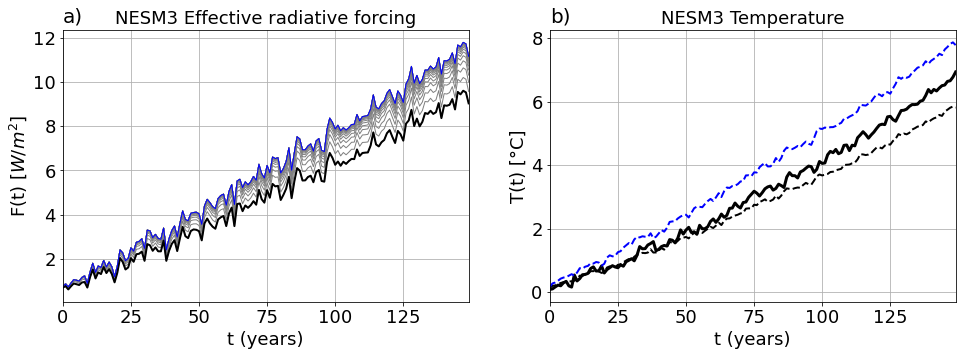

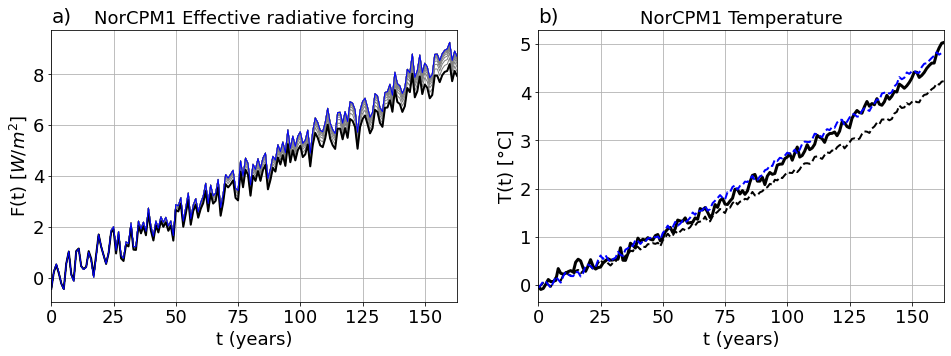

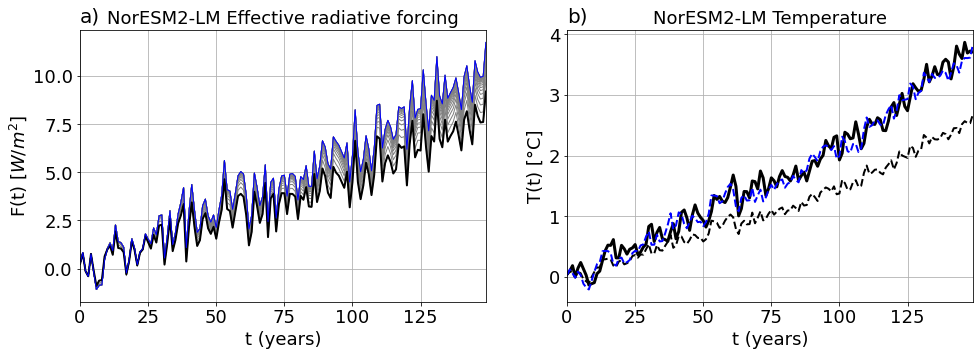

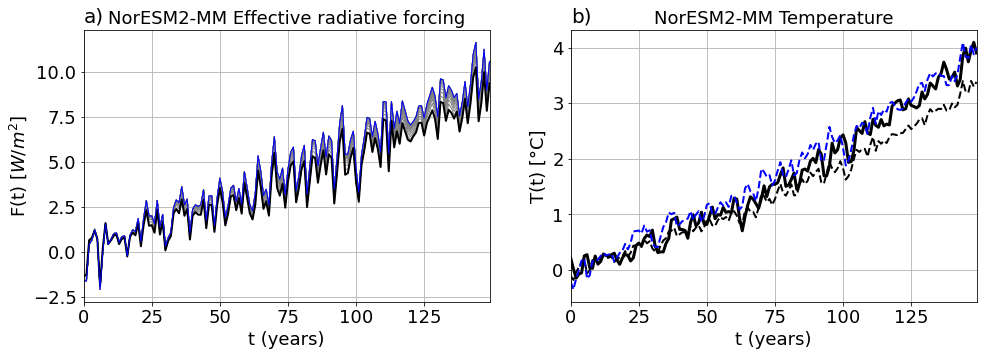

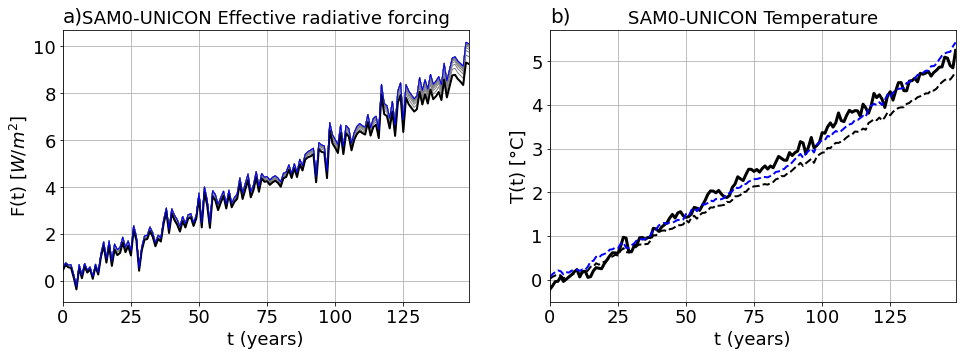

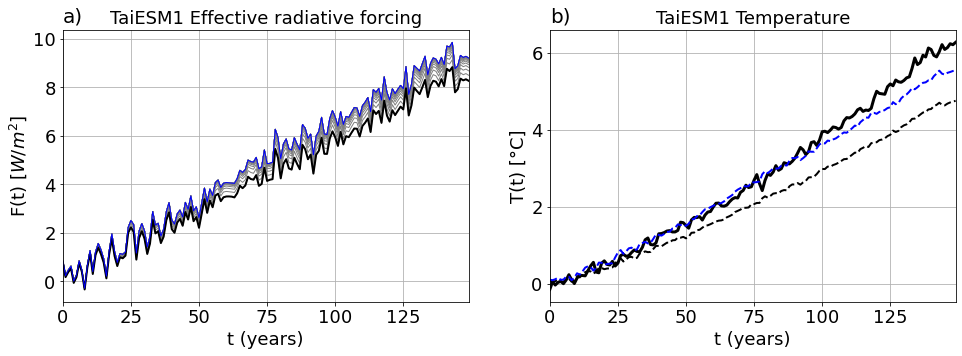

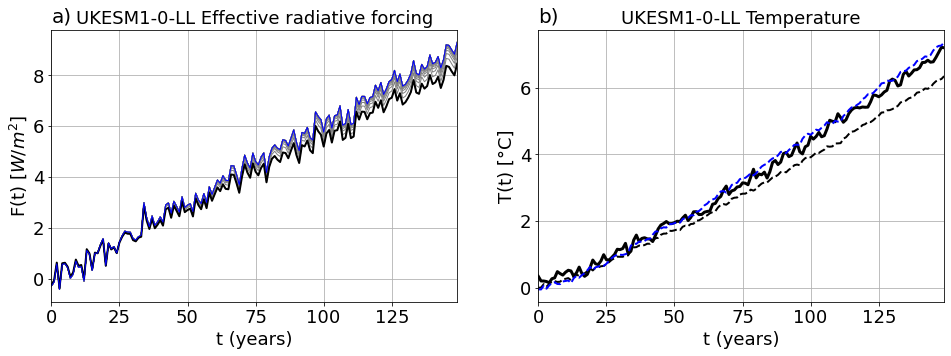

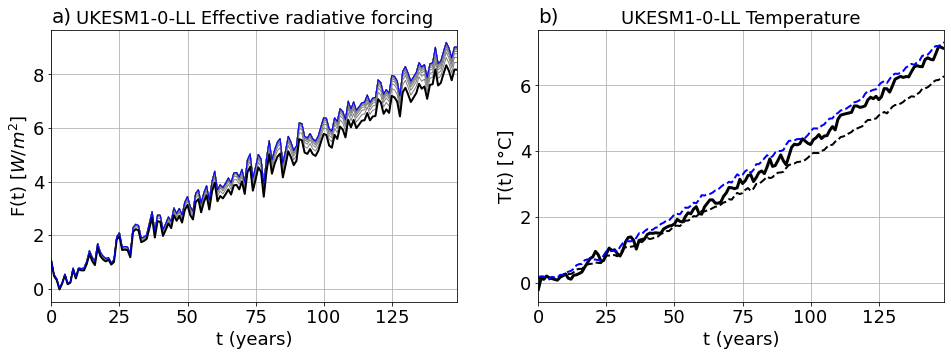

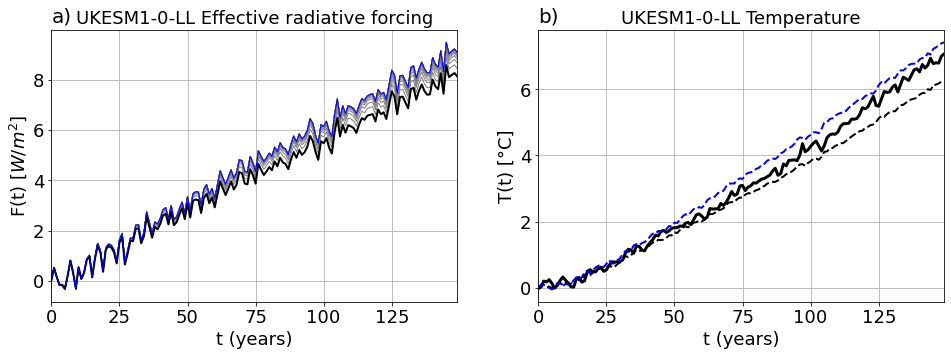

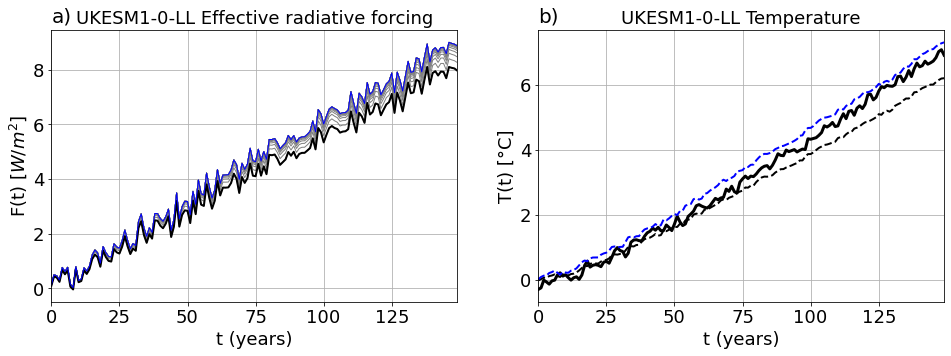

In [24]:
units = [' [K]', ' [W/$m^2$]', ' [W/$m^2$]', ' [W/$m^2$]']
importlib.reload(f)
exp = '1pctCO2'

for model in models:
#for model in ['UKESM1-0-LL']:
    members = f.find_members(model, exp)
    for member in members:
    #for member in ['r1i1p1f2']:

        data = f.load_anom(model, exp, member)
        N = data['rsdt'] - data['rsut'] - data['rlut']
        years = np.arange(0, len(data));
        #variables = list(data)

        #f.plot_allvar_preloaded(years, data, model, member, plot_title = model + ' ' + exp + ' ' + member)
        #f.plot_tasandN(years, data['tas'], N, plot_title = model + ' ' + exp + ' ' + member)

        F = f.forcing_F13(data['tas'], N, model)

        # load parameters needed to make new forcing estimate:
        filename = 'best_estimated_parameters_allmembers.txt'

        parameter_table = pd.read_table('../Estimates/' + filename,index_col=0)
        taulist = np.array(parameter_table.loc[model,'tau1':'tau3'])
        a_n = np.array(parameter_table.loc[model,'a_1':'a_4'])
        b_n = np.array(parameter_table.loc[model,'b_1':'b_4'])
        F2x = parameter_table.loc[model,'F2x']
        T2x = parameter_table.loc[model,'T2x']

        dim = len(taulist)
        if any(a_n == 0):
            dim = np.count_nonzero(a_n[:dim])
            zeroindex = np.where(a_n == 0)[0]
            a_n = np.delete(a_n,zeroindex)
            b_n = np.delete(b_n,zeroindex)
            taulist = np.delete(taulist,zeroindex)
        fbparlist = (b_n/a_n)[:dim]
        amplitudes = a_n[:dim]/(2*F2x*taulist)

        t = np.arange(0,len(F))
        #tas_pred = f.tas_predictors(t, taulist, exptype = 'timevaryingforcing', timevaryingforcing = F)
        #Tn = amplitudes*tas_pred

        # Compute new estimate of forcing
        it = 20  # number of iterations
        Fiarray = np.full((len(F),it),np.nan)
        Tiarray = np.full((len(F),it),np.nan)

        Fi = F
        for i in range(0,it):
            tas_pred = f.tas_predictors(t, taulist, exptype = 'timevaryingforcing',\
                                        timevaryingforcing = Fi)
            Tni = amplitudes*tas_pred
            Fi = N + Tni@fbparlist
            Fiarray[:,i] = Fi; Tiarray[:,i] = np.sum(Tni,axis=1)

        #f.plot_components(years, Tn, taulist)

        f.forcing_response_figure(years, Fiarray, Tiarray, Tcoupled = data['tas'], model = model)

        if saveforcingfigure == True:
            plt.savefig('../Figures/Transient_forcing_response/' + model + '_' + exp + '_' + member + '_forcing_and_response.pdf', format='pdf', dpi=600, bbox_inches="tight")
        #plt.close()

        if saveforcingdata == True:
            # create model directory if it does not already exist
            if os.path.isdir('../Estimates/Transient_forcing_estimates/' + model) == False:
                os.makedirs('../Estimates/Transient_forcing_estimates/' + model)
            index = pd.Index(years, name='Year')

            # save files
            df_F13 = pd.DataFrame(F.values, index=index, columns=['ERF'])
            modelfilename = model + '_' + exp + '_' + member + '_F13_ERF.txt'
            df_F13.to_csv('../Estimates/Transient_forcing_estimates/' + model + '/' + modelfilename, sep='\t')

            df_F = pd.DataFrame(Fiarray[:,-1], index=index, columns=['ERF'])
            modelfilename = model + '_' + exp + '_' + member + '_ERF.txt'
            df_F.to_csv('../Estimates/Transient_forcing_estimates/' + model + '/' + modelfilename, sep='\t')

        if save_tasdiff == True:
            # save difference between linear response to new forcing and coupled model tas
            tas_diff = Tiarray[:,-1] - data['tas']
            index = pd.Index(years, name='Year')
            df_tas = pd.DataFrame(tas_diff.values, index=index, columns=['tas_diff'])
            tas_filename = model + '_' + exp + '_' + member + '_tas_diff.txt'
            df_tas.to_csv('../Estimates/Transient_forcing_estimates/' + model + '/' + tas_filename, sep='\t')




## Put all data in one figure:

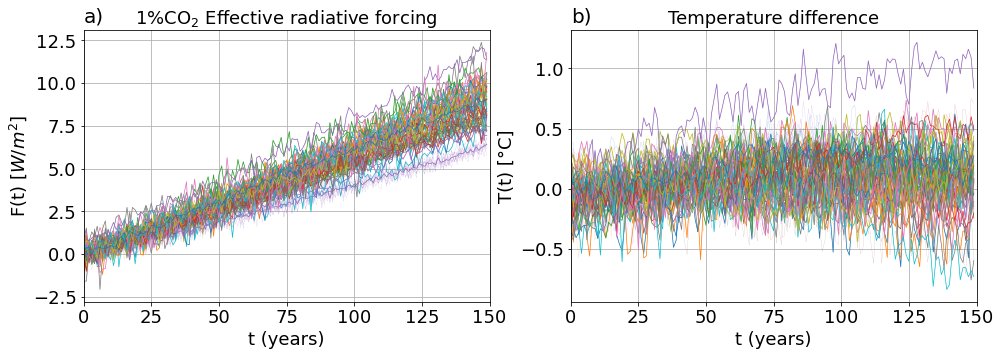

In [4]:
#importlib.reload(f)
exp = '1pctCO2'
estimated_4xCO2forcing = {}
member_mean_ERF = {}

fig, ax = plt.subplots(nrows=1,ncols=2,figsize = [16,5])
for axis in ax:
    axis.set_xlabel('t (years)',fontsize = 18)
    axis.set_xlim(0,150)
    axis.grid()
    axis.tick_params(axis='both',labelsize=18)

# assign one color to each model:
palette = sns.color_palette(None, len(model_names))
    
for (i,model) in enumerate(model_names):
#for (i,model) in enumerate(['FGOALS-g3']):
    members = find_members(model, exp)
    if model == 'GISS-E2-1-G':
        members.remove('r1i1p1f1') # has CO2 increase only up to doubling
        members.remove('r102i1p1f1')
    #print(model, members)
    model_ERFs = None
    for member in members: # plot very thin lines for individual members
        modeldir = '../Estimates/Transient_forcing_estimates/' + model + '/' + exp + '/'
        modelfilename = model + '_' + exp + '_' + member + '_ERF.csv'
        #ERF = pd.read_csv(modeldir + modelfilename,index_col=0)[:150]
        ERF_df = pd.read_csv(modeldir + '/' + modelfilename,index_col=0)
        # set new index to be used for plotting all data on the same axis
        #ERF = ERF_df.reset_index('Year')['ERF'].values[:150]
        ERF = pd.DataFrame(ERF_df.reset_index('Year')['ERF'][:150])
        tas_filename = model + '_' + exp + '_' + member + '_tas_diff.csv'
        #tas_diff = pd.read_csv(modeldir + tas_filename,index_col=0)[:150]
        tas_diff_df = pd.read_csv(modeldir + '/' + tas_filename,index_col=0)
        #tas_diff = tas_diff_df.reset_index('Year')['tas_diff'].values[:150]
        tas_diff = pd.DataFrame(tas_diff_df.reset_index('Year')['tas_diff'][:150])
        
        if model_ERFs is not None:
            model_ERFs = np.concatenate((model_ERFs, ERF), axis=1)
            model_tas_diffs = np.concatenate((model_tas_diffs, tas_diff), axis=1)
        else:
            model_ERFs = ERF
            model_tas_diffs = tas_diff
            
        ax[0].plot(ERF, linewidth = 0.1, color = palette[i])
        ax[0].set_ylabel('F(t) [$W/m^2$]',fontsize = 18)
        ax[0].set_title('1%CO$_2$ Effective radiative forcing',fontsize = 18)
        
        ax[1].plot(tas_diff, linewidth = 0.1, color = palette[i])
        ax[1].set_ylabel('T(t) [°C]',fontsize = 18)
        ax[1].set_title('Temperature difference',fontsize = 18)
    
    # plot thicker lines for mean of members (also models with only one member)
    member_mean_ERF[model] = np.mean(model_ERFs, axis=1)
    member_mean_tas_diff = np.mean(model_tas_diffs, axis=1)
    ax[0].plot(member_mean_ERF[model], linewidth = 0.7, color = palette[i], label = model)
    ax[1].plot(member_mean_tas_diff, linewidth = 0.7, color = palette[i])
    #estimated_4xCO2forcing[model] = np.mean(member_mean_ERF[model][140])
    #estimated_4xCO2forcing[model] = np.mean(member_mean_ERF[model][130:151])
    t = np.arange(140); y = member_mean_ERF[model][:140]
    p = np.polyfit(t, y, deg=2); quadfit = np.polyval(p, t)
    estimated_4xCO2forcing[model] = quadfit[-1]
#fig.legend(fontsize = 14)

ax[0].text(0,1.03,'a)',transform=ax[0].transAxes, fontsize=20)
ax[1].text(0,1.03,'b)',transform=ax[1].transAxes, fontsize=20);
#plt.savefig('../Figures/onepctCO2forcings.pdf', format='pdf', dpi=600, bbox_inches="tight")


## Test linear fit

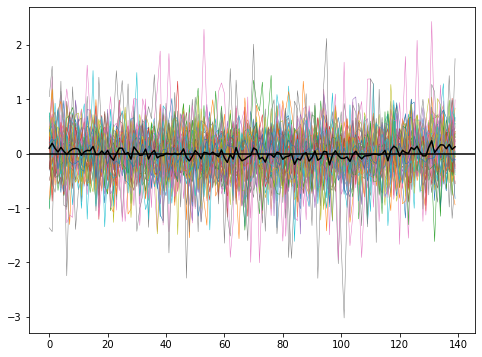

In [6]:
fig, ax = plt.subplots(figsize = [8,6])

t = np.arange(1,141)
detr_vals = np.zeros((140,len(model_names)))

for (i,model) in enumerate(model_names):
    y = member_mean_ERF[model][:140]
    p = np.polyfit(t, y, deg=1)
    linfit = np.polyval(p, t)
    plt.plot(y - linfit, linewidth = 0.5)
    detr_vals[:,i] = y - linfit
plt.plot(np.mean(detr_vals, axis=1), color = 'black')
plt.axhline(0, color = 'black')

Forcing increases slightly more than linearly. And it seems to be well described on average by a second order polynomial fit, with a positive coefficient of the squared term for most of the models

## Test quadratic fit

2.632312384482946e-06
4.50835908319238e-05
7.676576632593502e-05
5.73971046578422e-05
3.565208458521241e-05
3.063207490804081e-05
0.00015015679676923062
0.00014607137796602388
9.096731099246157e-05
6.140203135860154e-05
-1.6720510310534392e-05
-3.9958654735879465e-05
4.9639082981049214e-05
-1.1380631366431107e-06
3.6034434637771724e-05
9.13159566300884e-05
8.262697467180695e-06
2.603204044036834e-05
4.4639402809382547e-05
6.132184522436645e-05
1.5538767635596262e-05
-5.830650705818513e-06
3.022493687162646e-05
3.527346652513013e-05
2.5967007971292453e-05
9.160508257679796e-06
1.7470336063369828e-05
4.3083359670942735e-06
-1.924853490725048e-05
4.401125245899768e-05
4.916123692194771e-05
4.581016815329266e-05
-0.00017130891402966734
-5.293202875778564e-05
6.194298820940687e-05
2.8570307413681654e-05
7.373572061497604e-05
-6.494428473440555e-05
5.150129664573099e-05
8.661914431559371e-05
9.371365993584154e-05
-3.365915706248931e-05
6.807966555308196e-05
5.218928574249583e-05
3.8939864272

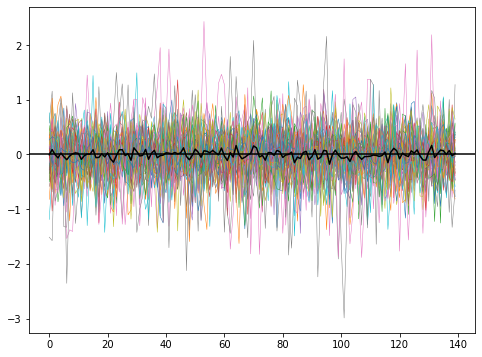

In [7]:
fig, ax = plt.subplots(figsize = [8,6])

t = np.arange(1,141)
detr_vals = np.zeros((140,len(model_names)))

for (i,model) in enumerate(model_names):
    y = member_mean_ERF[model][:140]
    p = np.polyfit(t, y, deg=2)
    print(p[0])
    quadfit = np.polyval(p, t)
    plt.plot(y - quadfit, linewidth = 0.5)
    detr_vals[:,i] = y - quadfit
plt.plot(np.mean(detr_vals, axis=1), color = 'black')
plt.axhline(0, color = 'black')

## Scatter plot of 4xCO2 forcings

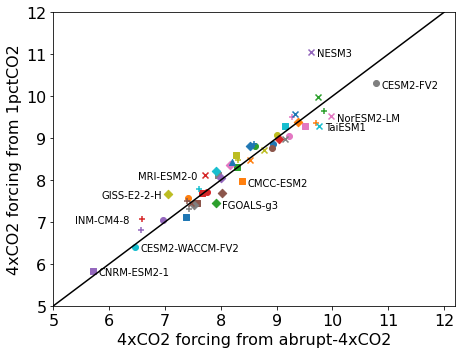

In [9]:
fig, ax = plt.subplots(figsize = [6*1.2,4.5*1.2])
ax.set_xlabel('4xCO2 forcing from abrupt-4xCO2',fontsize = 16)
ax.set_ylabel('4xCO2 forcing from 1pctCO2',fontsize = 16)
ax.tick_params(axis='both',labelsize=16)

# palette has only 10 different values, so we need different symbols for the same colors
symbols = ["o", "s", "D", "+", "x", "^"]

# load parameters needed to make new forcing estimate:
filename = 'best_estimated_parameters_allmembers.csv'
parameter_table = pd.read_csv('../Estimates/' + filename,index_col=0)
for (i, model) in enumerate(model_names):
    F4x = 2*parameter_table.loc[model,'F2x']
    plt.scatter(F4x, estimated_4xCO2forcing[model], color = palette[i], marker = symbols[int(i/10)])
    if np.abs(estimated_4xCO2forcing[model]-F4x)>0.4:
        #print(model, np.round(estimated_4xCO2forcing[model],2), np.round(F4x,2))
        if model in ['INM-CM4-8', 'GISS-E2-2-H', 'MRI-ESM2-0']:
            ax.text(F4x-1.2, estimated_4xCO2forcing[model]-0.1, model, size = 10)
        else:
            ax.text(F4x+0.1, estimated_4xCO2forcing[model]-0.1, model, size = 10)
    if estimated_4xCO2forcing[model]<6.5:
        ax.text(F4x+0.1, estimated_4xCO2forcing[model]-0.1, model, size = 10)
ax.plot([5,12], [5,12],color = 'black')
ax.set_xlim(5,12.2); ax.set_ylim(5,12);

#plt.savefig('../Figures/forcing_comparison_4xCO2.pdf', format='pdf', dpi=600, bbox_inches="tight")
